In [1]:
import numpy as np
import networkx as nx
import qiskit
from qiskit import Aer

from utils import graph_funcs, helper_funcs
from ansatz import dqv_ancilla_ansatz, dqva

from NuOp import gates_numpy
from NuOp import parallel_two_qubit_gate_decomposition as nuop

# No ancilla comparison

In [117]:
theta = np.pi / 2 
qubits = qiskit.QuantumRegister(4)
ancilla_circ = qiskit.QuantumCircuit(qubits)
ancilla_circ.mcrx(theta, qubits[:3], qubits[3])
ancilla_circ.measure_all()
ancilla_circ.draw(fold=-1)

┌───┐                      ┌───┐                     ┌───┐                      ┌───┐                      ░ ┌─┐         
q9543_0: ──────────────────────────────────────────────────────────────────────────┤ X ├──────────■───────────┤ X ├──────────■──────────┤ X ├──────────■───────────┤ X ├──────────■───────────░─┤M├─────────
                              ┌───┐                      ┌───┐                     └─┬─┘          │           └─┬─┘          │          └─┬─┘          │           └─┬─┘          │           ░ └╥┘┌─┐      
q9543_1: ─────────────────────┤ X ├──────────■───────────┤ X ├──────────■────────────■────────────┼─────────────┼────────────┼────────────■────────────┼─────────────┼────────────┼───────────░──╫─┤M├──────
                              └─┬─┘          │           └─┬─┘          │                         │             │            │                         │             │            │           ░  ║ └╥┘┌─┐   
q9543_2: ──────────■────────────■────────────┼─────────────■────────────┼─────────────────────────┼─────────────■────────────┼─────────────────────────┼─────────────■────────────┼───────────░──╫──╫─┤M├───
         ┌─────────┴─────────┐     ┌─────────┴──────────┐     ┌─────────┴─────────┐     ┌─────────┴──────────┐     ┌─────────┴─────────┐     ┌─────────┴──────────┐     ┌─────────┴─────────┐ ░  ║  ║ └╥┘┌─┐
q9543_3: ┤ U(π/8,-π/2,π/2,0) ├─────┤ U(-π/8,-π/2,π/2,0) ├─────┤ U(π/8,-π/2,π/2,0) ├─────┤ U(-π/8,-π/2,π/2,0) ├─────┤ U(π/8,-π/2,π/2,0) ├─────┤ U(-π/8,-π/2,π/2,0) ├─────┤ U(π/8,-π/2,π/2,0) ├─░──╫──╫──╫─┤M├
         └───────────────────┘     └────────────────────┘     └───────────────────┘     └────────────────────┘     └───────────────────┘     └────────────────────┘     └───────────────────┘ ░  ║  ║  ║ └╥┘
 meas: 4/════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                                                                                                                                 0  1  2  3

In [118]:
new_circ = qiskit.QuantumCircuit(qubits)
new_circ.rz(np.pi/2, qubits[3])
new_circ.ry(theta/2, qubits[3])
new_circ.mct(qubits[:3], qubits[3])
new_circ.ry(-theta/2, qubits[3])
new_circ.mct(qubits[:3], qubits[3])
new_circ.rz(-np.pi/2, qubits[3])
new_circ.measure_all()
new_circ.draw(fold=-1)

░ ┌─┐         
q9543_0: ────────────────────────■────────────────■───────────────░─┤M├─────────
                                 │                │               ░ └╥┘┌─┐      
q9543_1: ────────────────────────■────────────────■───────────────░──╫─┤M├──────
                                 │                │               ░  ║ └╥┘┌─┐   
q9543_2: ────────────────────────■────────────────■───────────────░──╫──╫─┤M├───
         ┌─────────┐┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐┌──────────┐ ░  ║  ║ └╥┘┌─┐
q9543_3: ┤ Rz(π/2) ├┤ Ry(π/4) ├┤ X ├┤ Ry(-π/4) ├┤ X ├┤ Rz(-π/2) ├─░──╫──╫──╫─┤M├
         └─────────┘└─────────┘└───┘└──────────┘└───┘└──────────┘ ░  ║  ║  ║ └╥┘
 meas: 4/════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                     0  1  2  3

In [85]:
def eval_basis_state(basis_state, circuit):
    qubits = circuit.qubits
    init_circ = qiskit.QuantumCircuit(qubits)
    for i, bit in enumerate(basis_state):
        if bit == '1':
            init_circ.x(qubits[i])
    
    result = qiskit.execute(init_circ + circuit, Aer.aer.get_backend('aer_simulator'), shots=100).result()
    
    return result.get_counts()

In [95]:
print('Basis states are ordered: q3q2q1q0')
print('Basis state, Old Circ, New Circ')
print('-'*31)
for basis_idx in range(int(2**4)):
    basis_state = f'{basis_idx:04b}'
    old_output = list(eval_basis_state(''.join(reversed(list(basis_state))), ancilla_circ).keys())
    new_output = list(eval_basis_state(''.join(reversed(list(basis_state))), new_circ).keys())
    print(' '*4, basis_state, ' '*4, *old_output, ' '*4, *new_output)

Basis states are ordered: q3q2q1q0
Basis state, Old Circ, New Circ
-------------------------------
     0000      0000      0000
     0001      0001      0001
     0010      0010      0010
     0011      0011      0011
     0100      0100      0100
     0101      0101      0101
     0110      0110      0110
     0111      1111      1111
     1000      1000      1000
     1001      1001      1001
     1010      1010      1010
     1011      1011      1011
     1100      1100      1100
     1101      1101      1101
     1110      1110      1110
     1111      0111      0111


In [119]:
ancilla_circ.remove_final_measurements()
new_circ.remove_final_measurements()

old_job = qiskit.execute(ancilla_circ, Aer.aer.get_backend('unitary_simulator'))
old_result = old_job.result()
old_unitary = old_result.get_unitary(ancilla_circ, decimals=3)

new_job = qiskit.execute(new_circ, Aer.aer.get_backend('unitary_simulator'))
new_result = new_job.result()
new_unitary = new_result.get_unitary(new_circ, decimals=3)

(old_unitary == new_unitary).all()

True

# MCRX gate

In [120]:
from qiskit.circuit import ControlledGate
from qiskit.circuit.library.standard_gates import RXGate

In [124]:
mcrx = ControlledGate('mcrx', 4, [2 * np.pi],
                      num_ctrl_qubits=3,
                      ctrl_state='000',
                      base_gate=RXGate(2 * np.pi))

In [126]:
qubits = qiskit.QuantumRegister(4)
circ = qiskit.QuantumCircuit(qubits)
circ.append(mcrx, qubits)
circ.draw()

q9570_0: ────o─────
             │     
q9570_1: ────o─────
             │     
q9570_2: ────o─────
         ┌───┴────┐
q9570_3: ┤ Rx(2π) ├
         └────────┘

## Test new gate and no-ancilla circuit

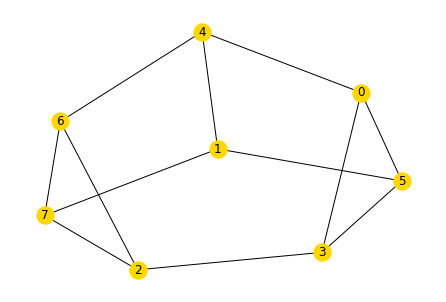

In [2]:
G = graph_funcs.graph_from_file('benchmark_graphs/N8_d3_graphs/G1.txt')
nx.draw_spring(G, with_labels=True, node_color='gold')

In [3]:
new_circ = dqva.gen_dqva(G, params=[1 for _ in range(G.number_of_nodes()+1)], barriers=2, decompose_toffoli=0)
new_circ.draw(fold=-1)

░           ░           ░           ░           ░           ░           ░ ┌───────┐ ░           ░  ░ ┌───────┐ ░  ░ 
q_0: ─░───────────░───────────░───────────░─────o─────░───────────░─────o─────░─┤ Rx(2) ├─░─────o─────░──░─┤ Rz(2) ├─░──░─
      ░           ░           ░           ░     │     ░ ┌───────┐ ░     │     ░ └───┬───┘ ░     │     ░  ░ ├───────┤ ░  ░ 
q_1: ─░───────────░─────o─────░───────────░─────┼─────░─┤ Rx(2) ├─░─────o─────░─────┼─────░─────o─────░──░─┤ Rz(2) ├─░──░─
      ░ ┌───────┐ ░     │     ░           ░     │     ░ └───┬───┘ ░     │     ░     │     ░     │     ░  ░ ├───────┤ ░  ░ 
q_2: ─░─┤ Rx(2) ├─░─────o─────░─────o─────░─────o─────░─────┼─────░─────┼─────░─────┼─────░─────┼─────░──░─┤ Rz(2) ├─░──░─
      ░ └───┬───┘ ░     │     ░     │     ░ ┌───┴───┐ ░     │     ░     │     ░     │     ░     │     ░  ░ ├───────┤ ░  ░ 
q_3: ─░─────o─────░─────┼─────░─────┼─────░─┤ Rx(2) ├─░─────┼─────░─────┼─────░─────o─────░─────o─────░──░─┤ Rz(2) ├─░──░─
      ░     │     ░     │     ░     │     ░ └───┬───┘ ░     │     ░ ┌───┴───┐ ░     │     ░     │     ░  ░ ├───────┤ ░  ░ 
q_4: ─░─────┼─────░─────┼─────░─────o─────░─────┼─────░─────o─────░─┤ Rx(2) ├─░─────o─────░─────┼─────░──░─┤ Rz(2) ├─░──░─
      ░     │     ░     │     ░     │     ░     │     ░     │     ░ └───┬───┘ ░     │     ░ ┌───┴───┐ ░  ░ ├───────┤ ░  ░ 
q_5: ─░─────┼─────░─────┼─────░─────┼─────░─────o─────░─────o─────░─────┼─────░─────o─────░─┤ Rx(2) ├─░──░─┤ Rz(2) ├─░──░─
      ░     │     ░     │     ░ ┌───┴───┐ ░           ░     │     ░     │     ░           ░ └───────┘ ░  ░ ├───────┤ ░  ░ 
q_6: ─░─────o─────░─────o─────░─┤ Rx(2) ├─░───────────░─────┼─────░─────o─────░───────────░───────────░──░─┤ Rz(2) ├─░──░─
      ░     │     ░ ┌───┴───┐ ░ └───┬───┘ ░           ░     │     ░           ░           ░           ░  ░ ├───────┤ ░  ░ 
q_7: ─░─────o─────░─┤ Rx(2) ├─░─────o─────░───────────░─────o─────░───────────░───────────░───────────░──░─┤ Rz(2) ├─░──░─
      ░           ░ └───────┘ ░           ░           ░           ░           ░           ░           ░  ░ └───────┘ ░  ░

In [4]:
old_circ = dqv_ancilla_ansatz.gen_dqva(G, params=[1 for _ in range(G.number_of_nodes()+1)], barriers=2, decompose_toffoli=0)
old_circ.draw(fold=-1)

░                     ░                     ░                     ░                     ░                     ░                     ░      ┌───────┐      ░                     ░  ░ ┌───────┐ ░  ░ 
  q_0: ─░─────────────────────░─────────────────────░─────────────────────░───o─────────────o───░─────────────────────░───o─────────────o───░──────┤ Rx(2) ├──────░───o─────────────o───░──░─┤ Rz(2) ├─░──░─
        ░                     ░                     ░                     ░   │             │   ░      ┌───────┐      ░   │             │   ░      └───┬───┘      ░   │             │   ░  ░ ├───────┤ ░  ░ 
  q_1: ─░─────────────────────░───o─────────────o───░─────────────────────░───┼─────────────┼───░──────┤ Rx(2) ├──────░───o─────────────o───░──────────┼──────────░───o─────────────o───░──░─┤ Rz(2) ├─░──░─
        ░      ┌───────┐      ░   │             │   ░                     ░   │             │   ░      └───┬───┘      ░   │             │   ░          │          ░   │             │   ░  ░ ├───────┤ ░  ░ 
  q_2: ─░──────┤ Rx(2) ├──────░───o─────────────o───░───o─────────────o───░───o─────────────o───░──────────┼──────────░───┼─────────────┼───░──────────┼──────────░───┼─────────────┼───░──░─┤ Rz(2) ├─░──░─
        ░      └───┬───┘      ░   │             │   ░   │             │   ░   │  ┌───────┐  │   ░          │          ░   │             │   ░          │          ░   │             │   ░  ░ ├───────┤ ░  ░ 
  q_3: ─░───o──────┼──────o───░───┼─────────────┼───░───┼─────────────┼───░───┼──┤ Rx(2) ├──┼───░──────────┼──────────░───┼─────────────┼───░───o──────┼──────o───░───o─────────────o───░──░─┤ Rz(2) ├─░──░─
        ░   │      │      │   ░   │             │   ░   │             │   ░   │  └───┬───┘  │   ░          │          ░   │  ┌───────┐  │   ░   │      │      │   ░   │             │   ░  ░ ├───────┤ ░  ░ 
  q_4: ─░───┼──────┼──────┼───░───┼─────────────┼───░───o─────────────o───░───┼──────┼──────┼───░───o──────┼──────o───░───┼──┤ Rx(2) ├──┼───░───o──────┼──────o───░───┼─────────────┼───░──░─┤ Rz(2) ├─░──░─
        ░   │      │      │   ░   │             │   ░   │             │   ░   │      │      │   ░   │      │      │   ░   │  └───┬───┘  │   ░   │      │      │   ░   │  ┌───────┐  │   ░  ░ ├───────┤ ░  ░ 
  q_5: ─░───┼──────┼──────┼───░───┼─────────────┼───░───┼─────────────┼───░───o──────┼──────o───░───o──────┼──────o───░───┼──────┼──────┼───░───o──────┼──────o───░───┼──┤ Rx(2) ├──┼───░──░─┤ Rz(2) ├─░──░─
        ░   │      │      │   ░   │             │   ░   │  ┌───────┐  │   ░   │      │      │   ░   │      │      │   ░   │      │      │   ░   │      │      │   ░   │  └───┬───┘  │   ░  ░ ├───────┤ ░  ░ 
  q_6: ─░───o──────┼──────o───░───o─────────────o───░───┼──┤ Rx(2) ├──┼───░───┼──────┼──────┼───░───┼──────┼──────┼───░───o──────┼──────o───░───┼──────┼──────┼───░───┼──────┼──────┼───░──░─┤ Rz(2) ├─░──░─
        ░   │      │      │   ░   │  ┌───────┐  │   ░   │  └───┬───┘  │   ░   │      │      │   ░   │      │      │   ░   │      │      │   ░   │      │      │   ░   │      │      │   ░  ░ ├───────┤ ░  ░ 
  q_7: ─░───o──────┼──────o───░───┼──┤ Rx(2) ├──┼───░───o──────┼──────o───░───┼──────┼──────┼───░───o──────┼──────o───░───┼──────┼──────┼───░───┼──────┼──────┼───░───┼──────┼──────┼───░──░─┤ Rz(2) ├─░──░─
        ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐└───┬───┘┌─┴─┐ ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐    │    ┌─┴─┐ ░ ┌─┴─┐    │    ┌─┴─┐ ░  ░ └───────┘ ░  ░ 
anc_0: ─░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░─┤ X ├────■────┤ X ├─░──░───────────░──░─
        ░ └───┘         └───┘ ░ └───┘         └───┘ ░ └───┘         └───┘ ░ └───┘         └───┘ ░ └───┘         └───┘ ░ └───┘         └───┘ ░ └───┘         └───┘ ░ └───┘         └───┘ ░  ░           ░  ░